# TODO
* in association of students with ACM, filter for active students. They are already naturally filtered for students who have received >0 minutes of tutoring. Alternatively, define 'active' as a student who has received >200 mins tutoring, or create some composite score that scales student assessment performance by tutoring time received
* teacher surveys
    * associate ACMs with teachers
* Conditions for success
* more survey items that were interesting from Q1
* incorporate Q2 and Q3 survey

# Next Steps/Cycle
1. decide attributes
    * dimensionality reduction, represent dataset with less data,but less transparency (PCA)
    * norm responses within individual responses (z-score seems standard here)
    * all if I can norm/encode programatically, then research feature selection scoring methods
    * use intuition/attributes I know are important
* Decide what scoring method to best select attributes
* Create decision tree
* Test other targets (measures of ACM effectiveness)

# Analysis Questions
* visualize tutoring time against growth
* visualize O&C scores against growth
* visualize growth against test date (whether baseline came from prior year or from fall)
* do SYACMs have greater impact? do they have greater impact when working with the same students?

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
# import pymc3 as pm
import seaborn as sns; sns.set_context('notebook')
os.chdir(r'Z:\ChiPrivate\Chicago Reports and Evaluation\SY18\Eval Management\ACM_analysis')

# Load shaped tables

In [15]:
# Student-level: tutoring time sum by student-program and associated to staff id via sections
tut_time_df = pd.read_csv('time_on_task_2017-12-11.csv')
# Student-level: Assessment performance vs target, no student-staff associations
assmt_df = pd.read_csv('assessment_growth.csv')
# ACM-level: each coaching instance YTD
heatmaps_df = pd.read_csv('OC_clean.csv')
# ACM-level: coaching data aggregated and normed, up to December
heatmaps_df_agg = pd.read_csv('OC_clean_agg.csv')
# ACM-level: Surveys
survey_df = pd.read_csv('ACM_surveys.csv')
# ACM-level: Projected Commute Time
commutes_df = pd.read_csv('commutes_cleaned.csv')

In [5]:
# merge assessments to tutoring time (including student-staff associations)
assmt_df['Assessment Type'] = assmt_df['Assessment Type'].str.replace('NWEA - ELA', 'Tutoring: Literacy')
assmt_df['Assessment Type'] = assmt_df['Assessment Type'].str.replace('NWEA - MATH', 'Tutoring: Math')
assmt_df['Key'] = assmt_df['Student__c'] + assmt_df['Assessment Type']
del assmt_df['Student__c']
tut_time_df['Key'] = tut_time_df['Student__c'] + tut_time_df['Program__c_Name']
impact_df = assmt_df.merge(tut_time_df, on='Key')
impact_df = impact_df.loc[impact_df['ToT_sum']>=90]

In [6]:
impact_df.head()

,Assessment Type,Growth_v_Target,Hit_Target?,Key,Section__c,Name,School__c,Program__c,In_After_School__c,Staff__c,Program__c_Name,Staff__c_Name,Role__c,Student__c,student_program,ToT_sum,ToT_mean,ToT_count
0,Tutoring: Literacy,-10.0,0.0,a1U1a000001GPtREAWTutoring: Literacy,a1A1a000004PwXBEA0,Tutoring: Literacy - AHernandez - Section - 77177,0011a00000jttlwAAA,a0x1a000001joW6AAI,In School,a1L1a0000035cbTEAQ,Tutoring: Literacy,Argenis Hernandez,Corps Member,a1U1a000001GPtREAW,a1U1a000001GPtREAW_a0x1a000001joW6,770.0,32.083333,24
1,Tutoring: Literacy,-1.0,0.0,a1U1a000001GPtWEAWTutoring: Literacy,a1A1a000004PwXBEA0,Tutoring: Literacy - AHernandez - Section - 77177,0011a00000jttlwAAA,a0x1a000001joW6AAI,In School,a1L1a0000035cbTEAQ,Tutoring: Literacy,Argenis Hernandez,Corps Member,a1U1a000001GPtWEAW,a1U1a000001GPtWEAW_a0x1a000001joW6,645.0,30.714286,21
2,Tutoring: Literacy,2.0,1.0,a1U1a000001GPtbEAGTutoring: Literacy,a1A1a000004PwXBEA0,Tutoring: Literacy - AHernandez - Section - 77177,0011a00000jttlwAAA,a0x1a000001joW6AAI,In School,a1L1a0000035cbTEAQ,Tutoring: Literacy,Argenis Hernandez,Corps Member,a1U1a000001GPtbEAG,a1U1a000001GPtbEAG_a0x1a000001joW6,750.0,31.250000,24
3,Tutoring: Math,-11.0,0.0,a1U1a000001GPtdEAGTutoring: Math,a1A1a000004PwiIEAS,Tutoring: Math - AHernandez - Section - 77197,0011a00000jttlwAAA,a0x1a000001joW7AAI,In School,a1L1a0000035cbTEAQ,Tutoring: Math,Argenis Hernandez,Corps Member,a1U1a000001GPtdEAG,a1U1a000001GPtdEAG_a0x1a000001joW7,865.0,37.608696,23
4,Tutoring: Literacy,-4.0,0.0,a1U1a000001GPthEAGTutoring: Literacy,a1A1a000004PwXBEA0,Tutoring: Literacy - AHernandez - Section - 77177,0011a00000jttlwAAA,a0x1a000001joW6AAI,In School,a1L1a0000035cbTEAQ,Tutoring: Literacy,Argenis Hernandez,Corps Member,a1U1a000001GPthEAG,a1U1a000001GPthEAG_a0x1a000001joW6,810.0,32.400000,25


In [32]:
# # experiment with scaling assessment growth by amount of time served by ACM
# impact_df.loc[impact_df['Hit_Target?']==1, 'Score_scaled_tot'] = impact_df['Amount_of_Time__c_YTD']
# impact_df.loc[impact_df['Hit_Target?']==0, 'Score_scaled_tot'] = -1*impact_df['Amount_of_Time__c_YTD']

response_i,c=α+β∗predictor_i,c+ϵ

In [33]:
data = impact_df[['Staff__c', 'ToT_mean', 'Growth_v_Target']]
data = data.sort_values('Staff__c')
data.reset_index(drop=True, inplace=True)
data.loc[:, 'Staff__c_code'] = data.Staff__c.map(dict(zip(data.Staff__c.unique(), list(range(0, len(data.Staff__c.unique()))))))
acms_idx = data.Staff__c_code

In [39]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.Staff__c.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.Staff__c.unique()))
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    growth_est = a[acms_idx] + b[acms_idx] * data.ToT_mean.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=growth_est, sd=eps, observed=data.Growth_v_Target)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '7636' (I am process '1012')


In [40]:
with hierarchical_model:
    hierarchical_trace = pm.sample(njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, beta, alpha, sigma_beta_log__, mu_beta, sigma_alpha_log__, mu_alpha]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.688421254017, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.680679124439, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


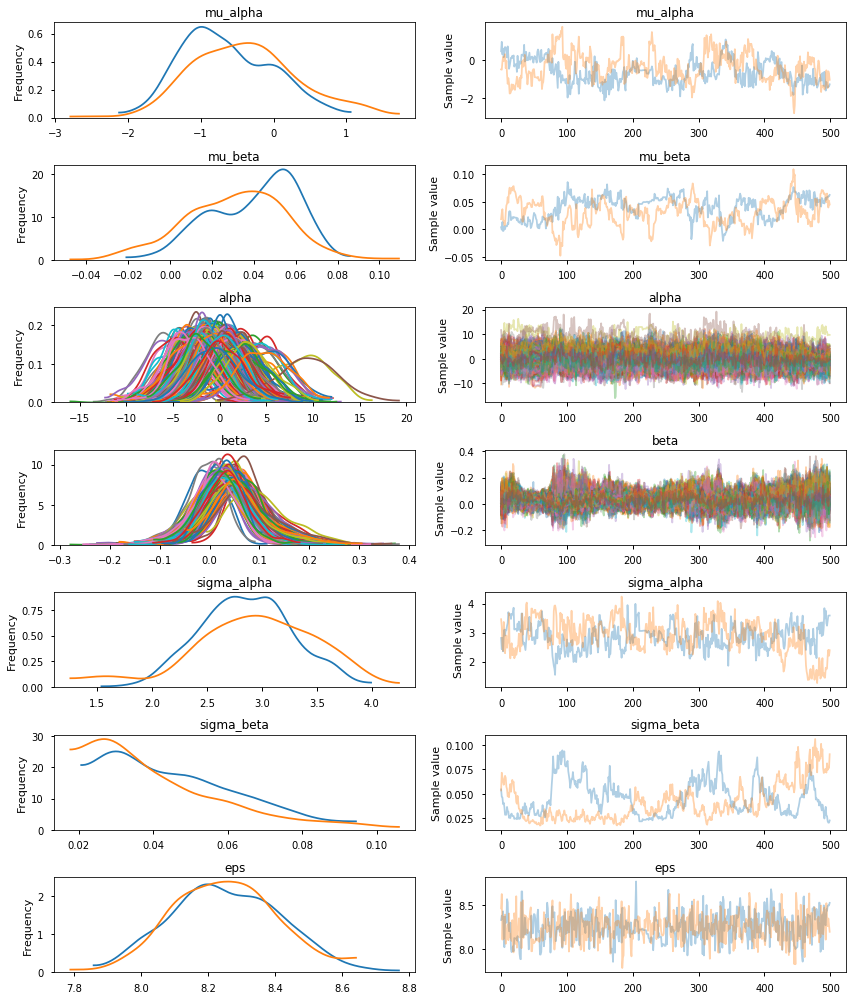

In [41]:
pm.traceplot(hierarchical_trace);

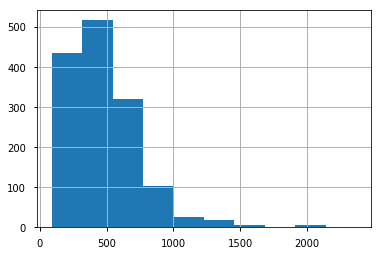

In [7]:
impact_df['ToT_sum'].hist()

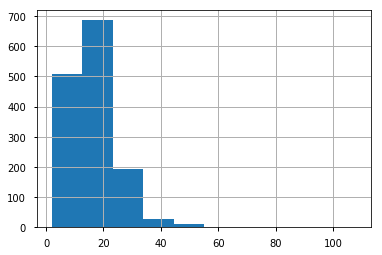

In [8]:
impact_df['ToT_count'].hist()

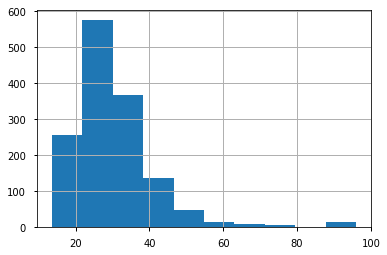

In [9]:
impact_df['ToT_mean'].hist()

In [10]:
impact_df['Growth_v_Target'].describe()

count    1427.000000
mean        0.531863
std         8.893959
min       -37.000000
25%        -5.000000
50%         0.000000
75%         5.000000
max       101.000000
Name: Growth_v_Target, dtype: float64

## Does Tutoring Time Relate to Assessment Growth?

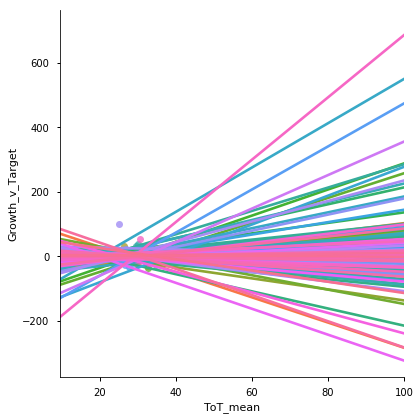

In [11]:
sns.lmplot(data=impact_df, x='ToT_mean', y='Growth_v_Target', hue='Staff__c', legend=False, size=6, ci=False)

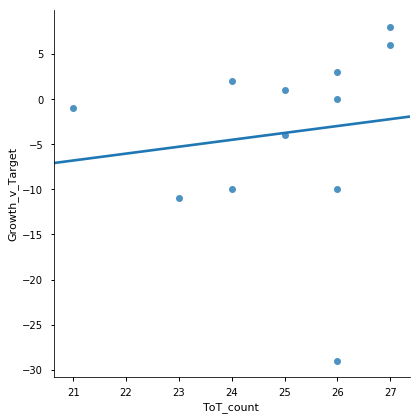

In [13]:
sns.lmplot(data=impact_df.loc[impact_df['Staff__c']=='a1L1a0000035cbTEAQ'], x='ToT_count', y='Growth_v_Target', legend=False, hue='Staff__c', size=6, ci=False)

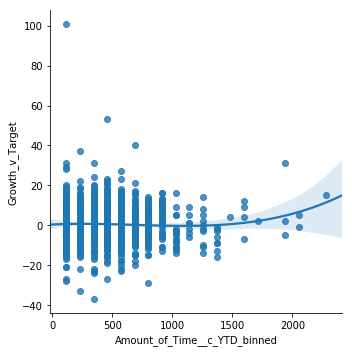

In [64]:
bin_size = 20
bin_range = (impact_df['ToT_sum'].max() - impact_df['ToT_sum'].min())/bin_size
impact_df.loc[:, 'ToT_sum_binned'] = pd.cut(impact_df['ToT_sum'], bin_size, labels=False)
impact_df.loc[:, 'ToT_sum_binned'] = (impact_df.loc[:, 'ToT_sum_binned']+1) * bin_range
sns.lmplot(data=impact_df, x='ToT_sum_binned', y='Growth_v_Target', order=3)

In [ ]:
sns.lmplot(data=impact_df, x='ToT_sum', y='Hit_Target?', hue='Staff__c', size=10, legend=False, ci=False)

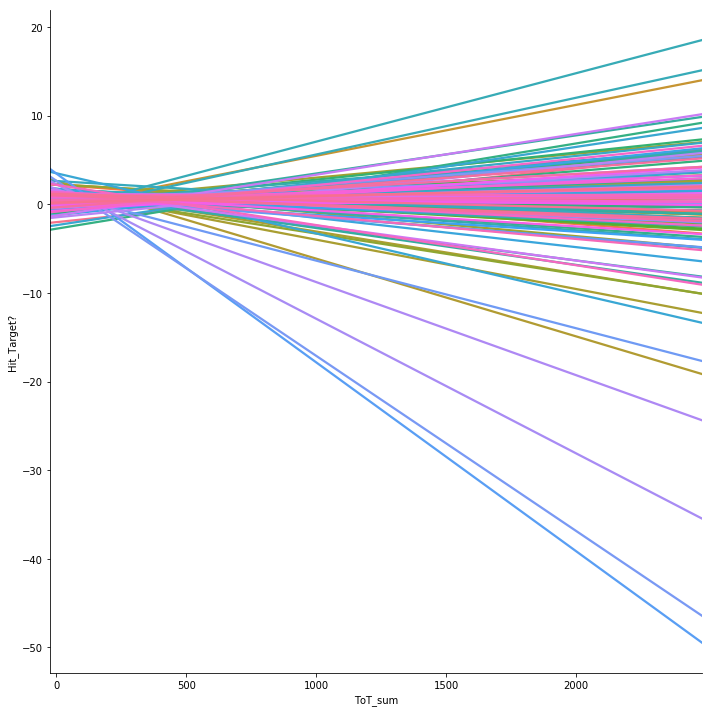

In [15]:
# logistic=True failed
sns.lmplot(data=impact_df, x='ToT_sum', y='Hit_Target?', hue='Staff__c', size=10, legend=False, ci=False)

In [ ]:
# # group to ACM level
# group1_df = impact_df.groupby('Staff__c').agg(['sum', 'mean', 'std', 'count']).reset_index()
# group1_df.columns = [' '.join(col).strip() for col in group1_df.columns.values]
# group2_df = impact_df.groupby('Staff__c')['School__c'].first().reset_index()
# impact_df = group1_df.merge(group2_df, on='Staff__c')

In [6]:
# impact_df['Score_scaled_tot'].hist()

### Experimenting with Different Scoring methods to aggregate student performance by ACM
Place greater value on N students who met target, penalize for N students who missed. [Graph](https://academo.org/demos/3d-surface-plotter/?expression=y%5E1.5-x%5E1.3&xRange=0%2C%2B12&yRange=0%2C%2B12&resolution=12)

In [8]:
impact_df['N Hit Target'] = impact_df['Hit_Target? mean'] * impact_df['Hit_Target? count']
impact_df['N Not Hit Target'] = impact_df['Hit_Target? count'] - impact_df['N Hit Target']
impact_df['Score'] = impact_df['N Hit Target']**1.5 - impact_df['N Not Hit Target']**1.3
# z-score normalization
impact_df['Score'] = (impact_df['Score'] - impact_df['Score'].mean()) / impact_df['Score'].std()

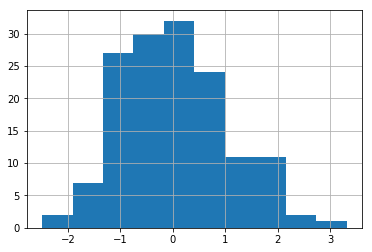

In [9]:
impact_df['Score'].hist()

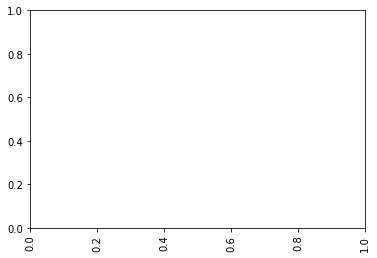

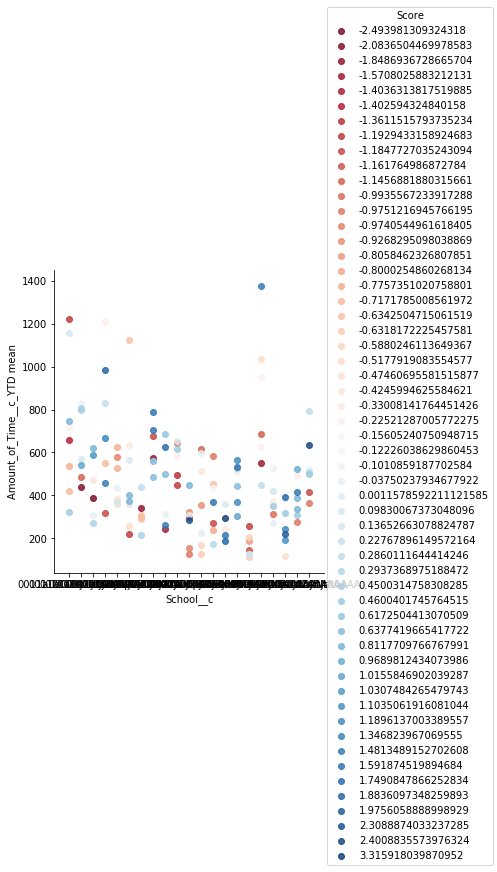

In [13]:
sns.lmplot(data=impact_df, x='School__c', y='Amount_of_Time__c_YTD mean', hue='Score', palette="RdBu", fit_reg=False)

In [3]:
sns.lmplot(x="School__c", y="Score", data=impact_df)

NameError: name 'impact_df' is not defined

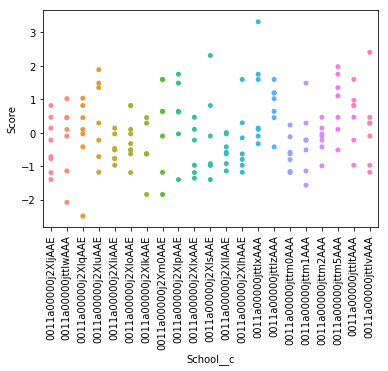

In [44]:
plt.xticks(rotation=90)
sns.stripplot(x="School__c", y="Score", data=impact_df)

In [30]:
len(tut_time_df.loc[tut_time_df.Amount_of_Time__c_YTD<200])

439

In [4]:
# mean_df.reset_index(inplace=True)
# df = mean_df.merge(survey_df, on='Staff__c')

In [58]:
# from sklearn_pandas import DataFrameMapper
# import numpy as np
# import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_selection import SelectKBest, chi2

# mapper = DataFrameMapper([('NPS', sklearn.preprocessing.LabelBinarizer()),
#                           ('Growth_v_Target mean', None)], df_out=True)

# mapper

# mapper_fs = DataFrameMapper([(['children','salary'], SelectKBest(chi2, k=1))])
# mapper_fs.fit_transform(data[['children','salary']], data['Growth_v_Target mean'])

# from sklearn import tree

# X = [[0, 0], [1, 1]]
# Y = [0, 1]
# clf = tree.DecisionTreeClassifier()
# clf = clf.fit(X, Y)

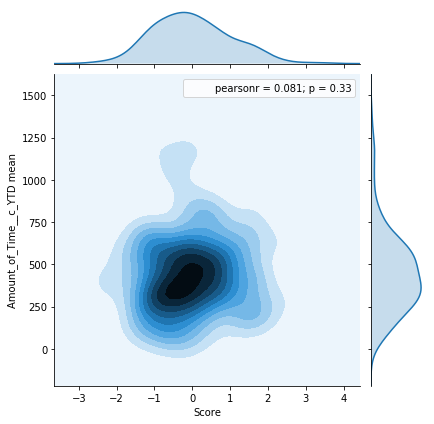

In [11]:
sns.jointplot(x='Score', y="Amount_of_Time__c_YTD mean", data=impact_df, kind="kde")

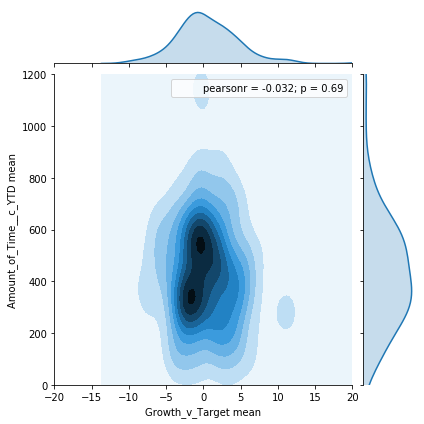

In [12]:
sns.jointplot(x="Growth_v_Target mean", y="Amount_of_Time__c_YTD mean", data=impact_df, kind="kde", xlim=(-20, 20), ylim=(0, 1200))

In [ ]:
mean_df[("Growth_v_Target", "mean")].hist()

In [ ]:
mean_df[("Hit_Target?", "mean")].hist()

# Compare O&C to Target

In [45]:
oc_df = heatmaps_df_agg.merge(impact_df[['Staff__c', 'Score', 'Hit_Target? mean']], on='Staff__c')

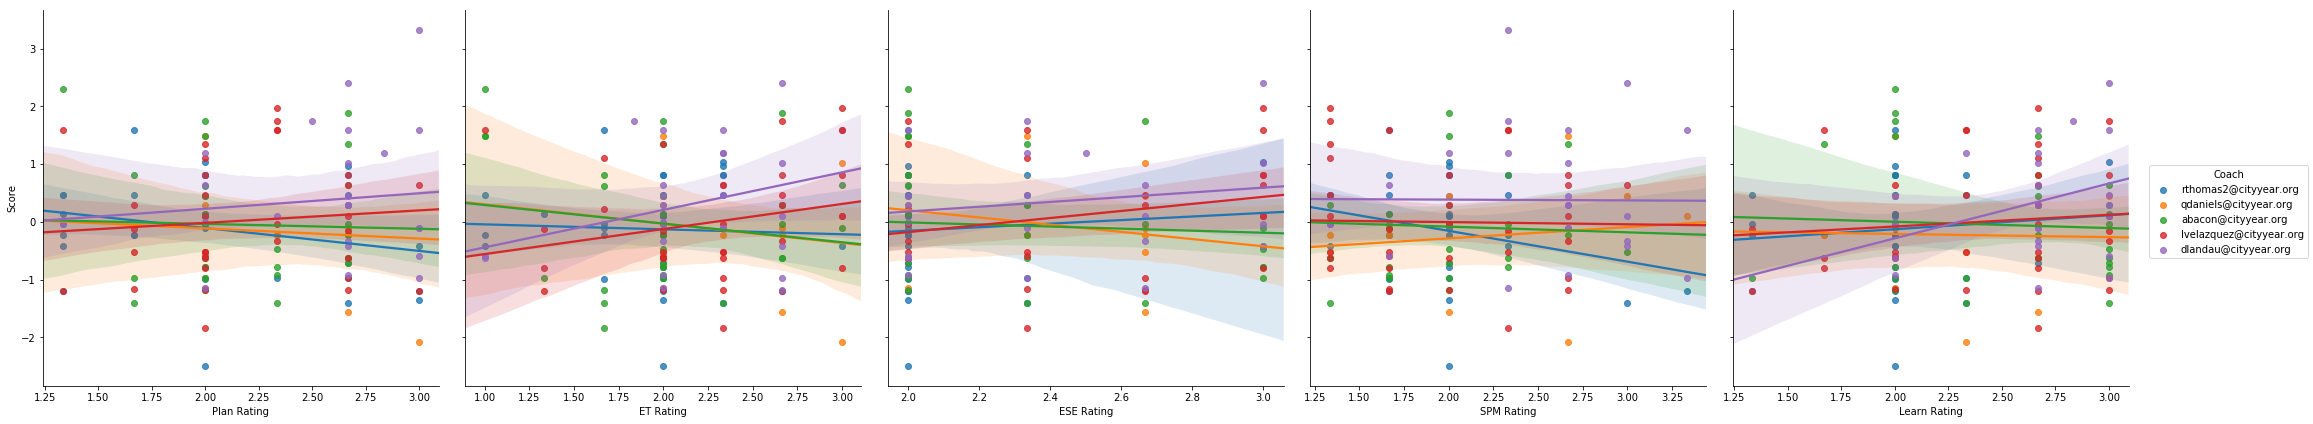

In [46]:
sns.pairplot(oc_df, x_vars=['Plan Rating', 'ET Rating','ESE Rating','SPM Rating','Learn Rating'], 
             y_vars=['Score'], kind="reg", hue='Coach', size=6)

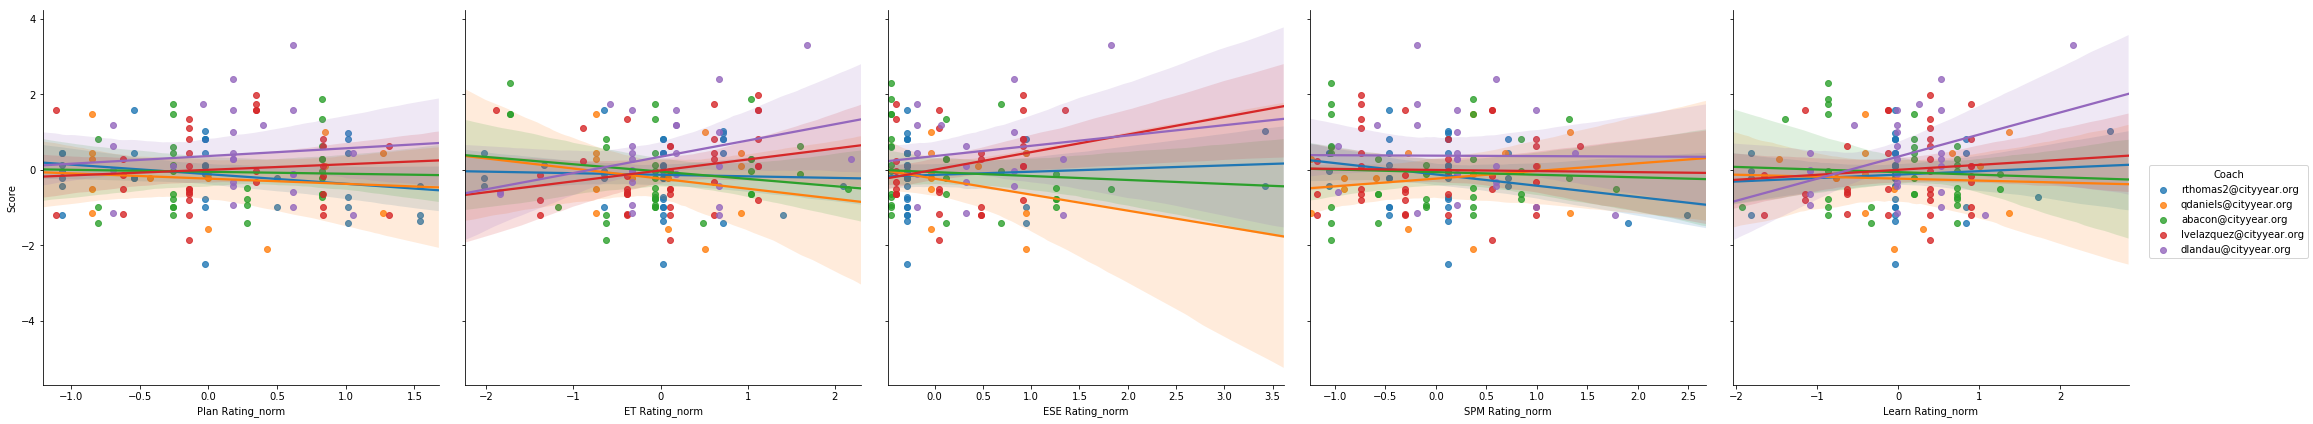

In [47]:
sns.pairplot(oc_df, x_vars=[col for col in oc_df.columns if '_norm' in col], 
             y_vars=['Score'], kind="reg", hue='Coach', size=6)

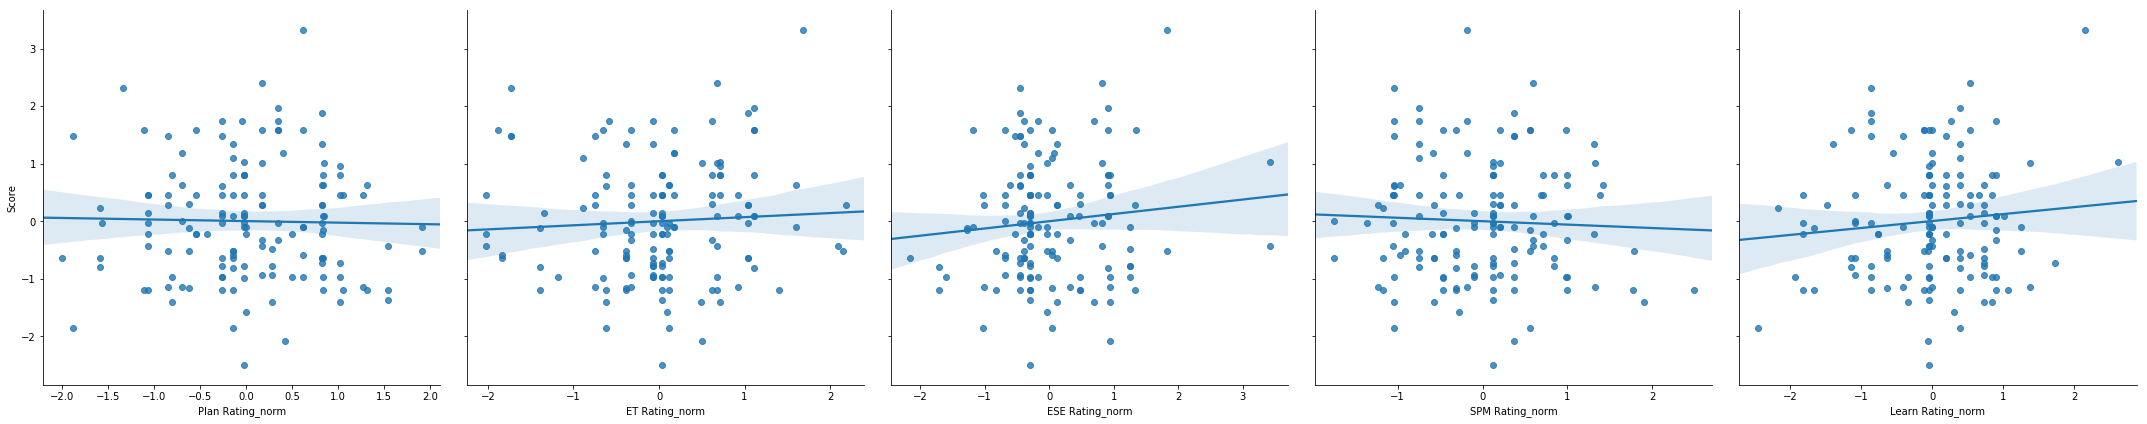

In [49]:
sns.pairplot(oc_df, x_vars=[col for col in oc_df.columns if '_norm' in col], 
             y_vars=['Score'], kind="reg", size=6)

# Compare Survey to Commutes

In [62]:
surv_commute_df = survey_df.copy()
surv_commute_df = surv_commute_df.merge(commutes_df, on='Staff__c', how='left')

surv_commute_df.loc[:, 'Q2_var51O96'] = surv_commute_df.loc[:, 'Q2_var51O96'].map({'Checked':1, 'Unchecked':0})
surv_commute_df.loc[:, 'Q3_var31'] = pd.to_numeric(surv_commute_df['Q3_var31'], errors='coerce')
surv_commute_df.loc[surv_commute_df['Commute.Time'] > 900, 'Commute.Time'] = np.nan
surv_commute_df.loc[surv_commute_df['Q3_var31'] > 900, 'Q3_var31'] = np.nan

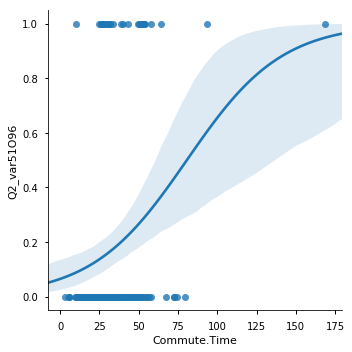

In [51]:
# Likelihood of Listing Commute as a Challenge (Y axis) vs. Predicted Commute (X axis)
sns.lmplot(x='Commute.Time', y='Q2_var51O96', data=surv_commute_df, logistic=True)

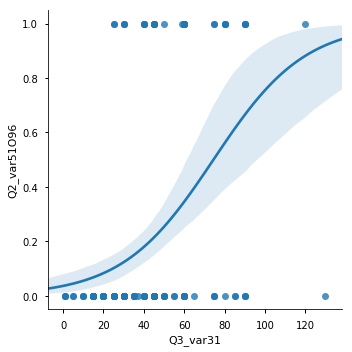

In [96]:
# Likelihood of Listing Commute as a Challenge (Y axis) vs. Self-Reported Commute (X axis)
sns.lmplot(x='Q3_var31', y='Q2_var51O96', data=surv_commute_df, logistic=True)

In [66]:
surv_commute_df.loc[:, 'Actual_vs_Predicted'] = surv_commute_df['Q3_var31'] - surv_commute_df['Commute.Time']

In [100]:
surv_commute_df['Q3_var32'].unique()

array(['Public transit', 'Car (my own)', 'Walking', nan,
       'Car (somebody else drives)', 'Biking'], dtype=object)

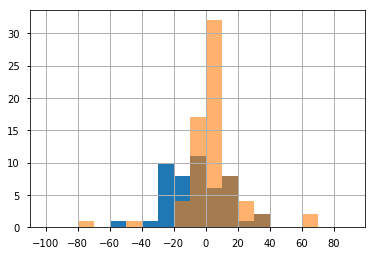

In [137]:
# Self-Reported Commute minus Predicted Commute
binwidth = 10
plt.xticks(range(-100, 100, 20))
data = surv_commute_df.loc[(~surv_commute_df['Q3_var31'].isnull() &
                            ~surv_commute_df['Commute.Time'].isnull() &
                            surv_commute_df['Q3_var32'].str.contains('Car')), 
                           'Actual_vs_Predicted']
data.hist(bins=range(-100, 100, binwidth))
data = surv_commute_df.loc[(~surv_commute_df['Q3_var31'].isnull() &
                            ~surv_commute_df['Commute.Time'].isnull() & 
                            surv_commute_df['Q3_var32'].str.contains('Public transit')),
                           'Actual_vs_Predicted']
data.hist(bins=range(-100, 100, binwidth), alpha=.6)

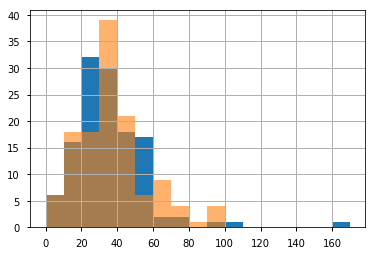

In [111]:
# Self-Reported Commute and Predicted Commute
binwidth = 10
plt.xticks(range(0, 200, 20))
data = surv_commute_df.loc[(~surv_commute_df['Q3_var31'].isnull() & ~surv_commute_df['Commute.Time'].isnull()), 'Commute.Time']
data.hist(bins=range(0, 175, binwidth))
data = surv_commute_df.loc[(~surv_commute_df['Q3_var31'].isnull() & ~surv_commute_df['Commute.Time'].isnull()), 'Q3_var31']
data.hist(alpha=0.6, bins=range(0, 175, binwidth))

# Compare Surveys to Target

In [73]:
survey_df = survey_df.merge(impact_df[['Staff__c', 'Score', 'Hit_Target? mean']], on='Staff__c')

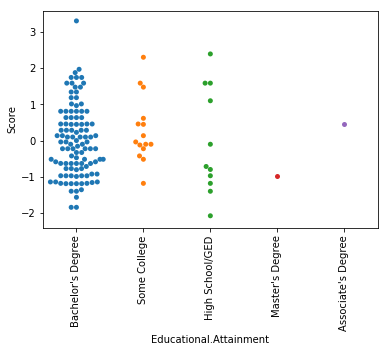

In [51]:
plt.xticks(rotation=90)
sns.swarmplot(x="Educational.Attainment", y="Score", data=survey_df)

C:\Users\City_Year\Anaconda3\envs\ACM_analysis\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


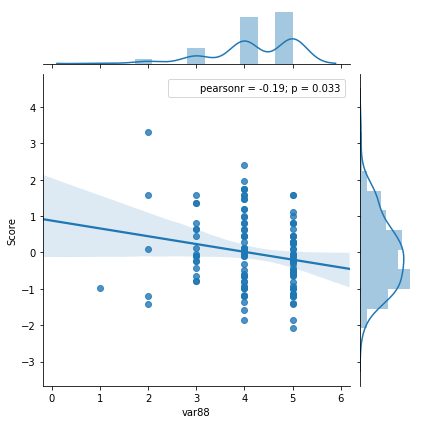

In [102]:
# var5	var31	var76	var77	var79	var80	var85	var86	var87	var88
sns.jointplot(x="var88", y="Score", data=survey_df, kind='reg')

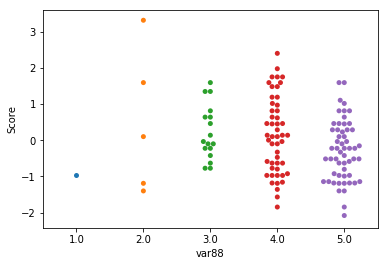

In [75]:
sns.swarmplot(x="var88", y="Score", data=survey_df)

In [53]:
survey_df.loc[survey_df['Tutoring.Experience.Months'].isnull(), 'Tutoring.Experience.Months'] = 0

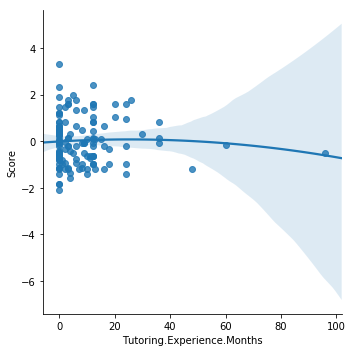

In [55]:
sns.lmplot(x="Tutoring.Experience.Months", y="Score", data=survey_df, order=2)

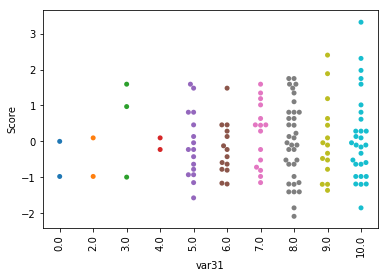

In [77]:
plt.xticks(rotation=90)
sns.swarmplot(x="var31", y="Score", data=survey_df)

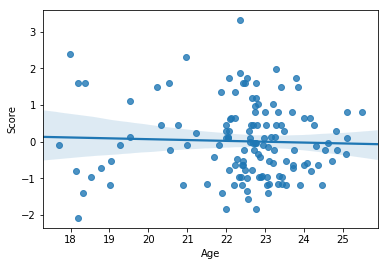

In [58]:
sns.regplot(x="Age", y="Score", data=survey_df)